In [1]:
#Import Libraries
import numpy as np

import skimage
from skimage.color import rgb2gray
from skimage import measure

import scipy
from scipy.ndimage import gaussian_filter
from scipy import signal
from scipy.fft import fft, ifft,fftfreq

import glob

#Import Loading Bar
from tqdm.notebook import tqdm

#Import plot and set plotting parameters
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid")
sns.set_context("talk", font_scale = 1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['figure.figsize'] = [10, 7]

# Code for processing entire surfactant image and analysis of wavelength distribution.

In [2]:
#Load in file containing surfactant images.
files = glob.glob(r".\6.0 mN.m_200um_26.ids - 140454 - Fingering Onset.gif")

In [3]:
#Load in image and extract contours of domains from thresholded image.
contours = []

p = 0

for i in tqdm([files[p]]):

    a = skimage.io.imread(i)

    contour = measure.find_contours(a <50, 0)
    
    contours.extend(contour)

  0%|          | 0/1 [00:00<?, ?it/s]

[]

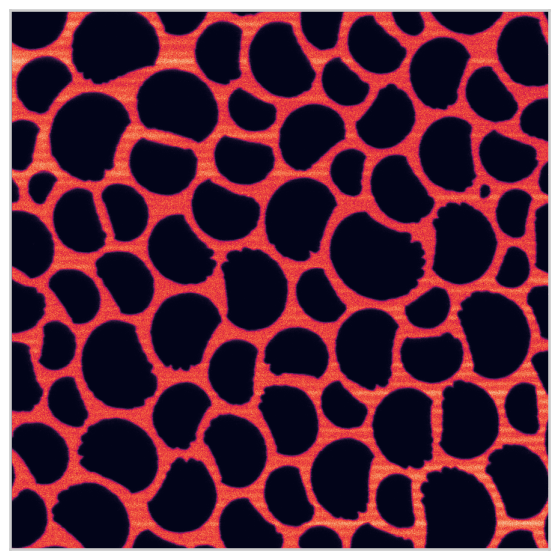

In [4]:
#Plot original image.
plt.imshow(a)

plt.axis('image')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

[]

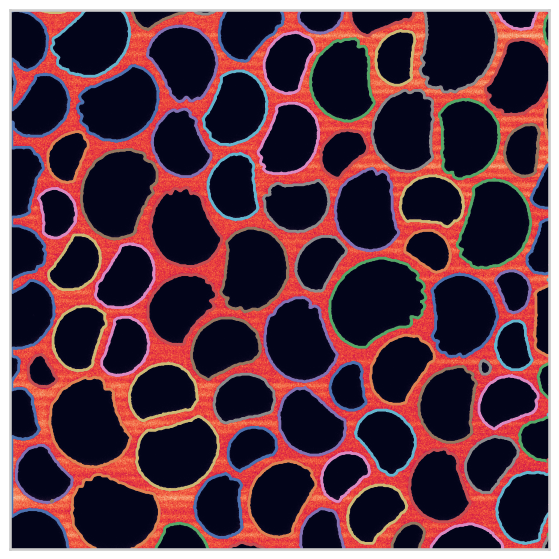

In [5]:
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(a, cmap=plt.cm.gray)

plt.imshow(a,origin = "lower")
plt.gca().axis('image')

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

In [6]:
#Define the highpass filter. We are applying both a highpass and lowpass (gaussian smoothing) filter on our images that act as 
#a bandpass filter.
def highpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 5):
    sos = scipy.signal.butter(poles, cutoff, 'highpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data

#We select only the larger contours to remove small contoured arifacts and threshold large contours to remove edge artifacts. 
big = []

for i in contours:
    if (len(i) > 220) & (len(i) < 850):
        big.append(i)

Freqs = []

shape = []


#Loop through each identified contour, compute distance to centroid, apply bandpass filter, and measure highest frequency. 
for i in big:

    contour = i
    
    # Calculate the centroid of the contour
    centroid = np.mean(contour, axis=0)
    
    # Compute distances of all points on the contour to the centroid
    distances = np.linalg.norm(contour - centroid, axis=1)

    #Apply gaussian filter to remove high-frequency noise.
    diffs = gaussian_filter(distances,2)

    #Apply high-pass filter to remove low frequency signal due to elliptic shape of the domains. 
    filtered = highpass(gaussian_filter(distances,2), 8, len(diffs))

    #Calculate overall length of contour.
    length = 0
    for k in range(np.shape(i)[0]-1):
        p1 = np.array([i[k,0],i[k,1]])
        p2 = np.array([i[k+1,0],i[k+1,1]])
        length += np.linalg.norm(p1 - p2)*.27

    #Record length of measured distance for frequency transform.
    N = np.shape(diffs)[0]
    shape.append(length)

    
    
    #Compute frequencyes and identify maximum frequency:
    T = 1/N
    
    yf = fft(filtered)

    xf = fftfreq(N, T)[:N//2]

    # peaks = scipy.signal.find_peaks(2.0/N * np.abs(yf[0:N//2]))

    ind = np.argmax(2.0/N * np.abs(yf[0:N//2]))

    Freqs.append(xf[ind])

Freqs = np.array(Freqs)


5.405073921609712


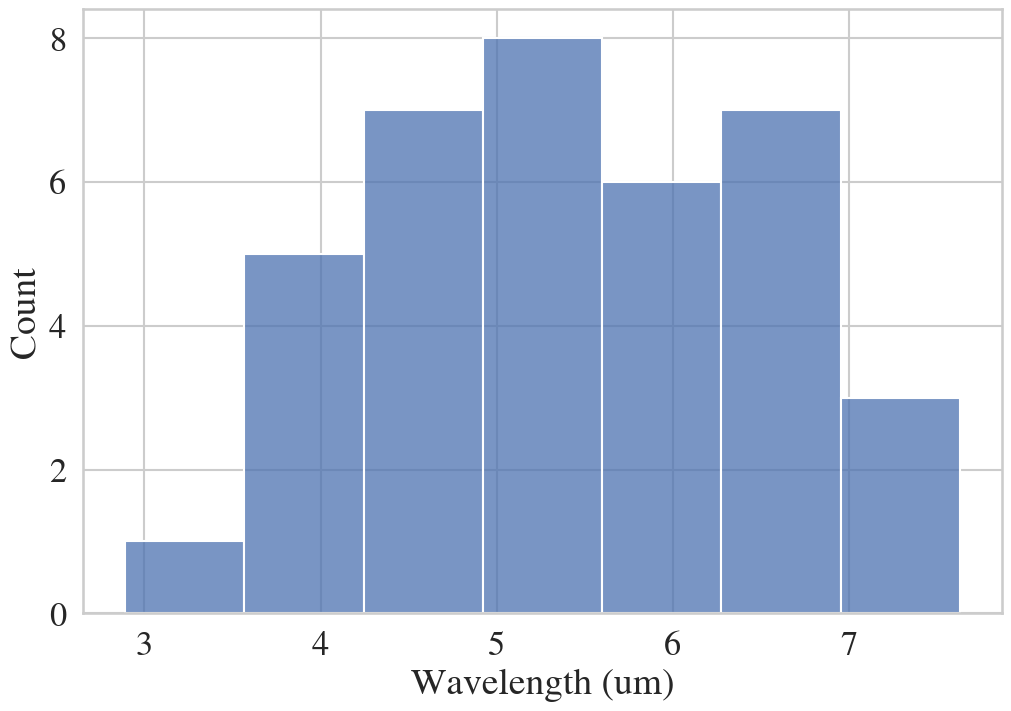

In [7]:
#Plot distribution of peak frequencies converted to wavelength:

plt.figure(constrained_layout=True)
sns.histplot((shape/Freqs)/1.4)
plt.xlabel("Wavelength (um)")

print(np.mean((shape/Freqs)/1.4))


# Example for single contour analysis.

Text(0, 0.5, 'Filtered Distance to Centroid')

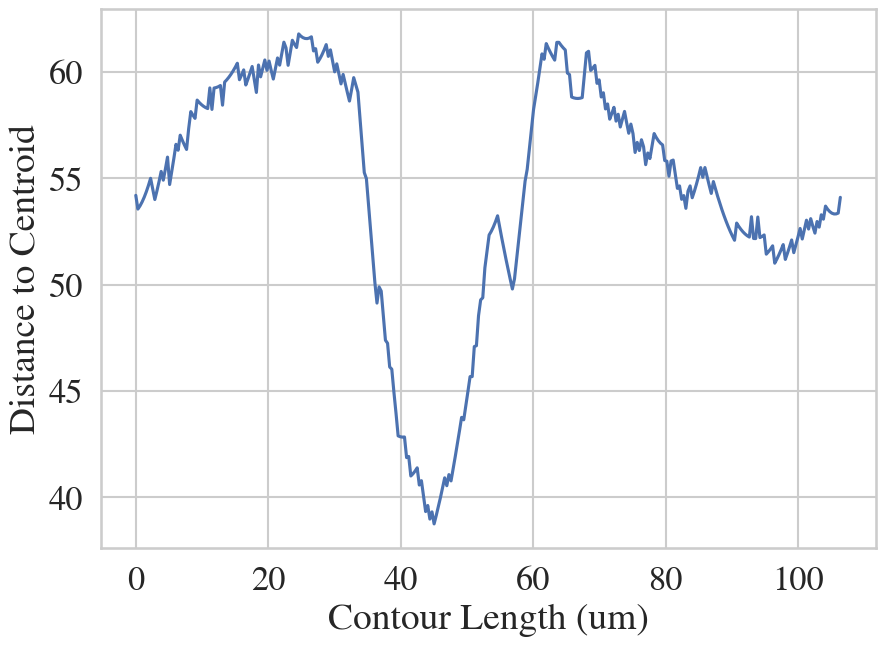

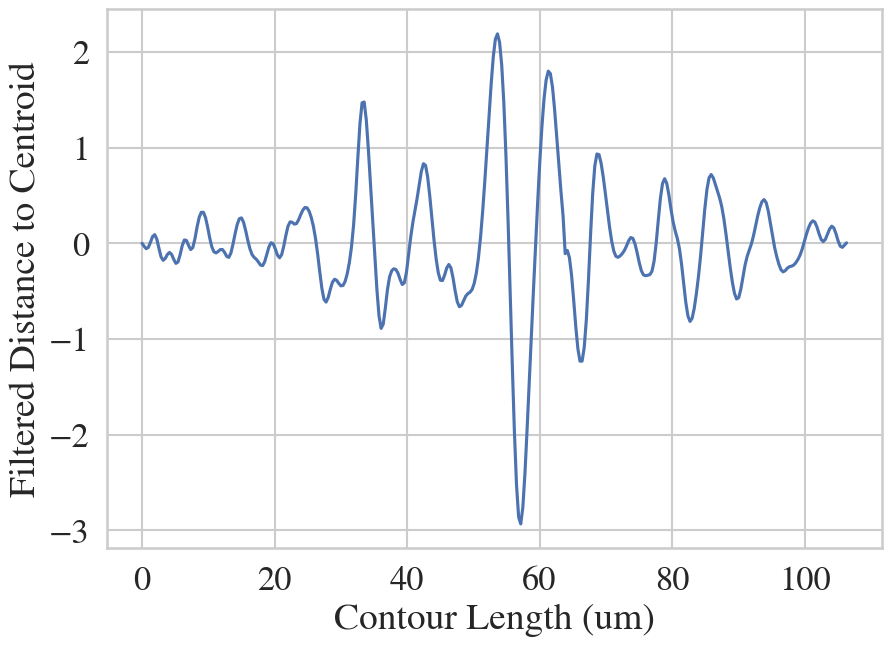

In [8]:
i = big[6]

xlen = np.linspace(0,shape[6],len(i))

contour = i

# Calculate the centroid of the contour
centroid = np.mean(contour, axis=0)

# Compute distances of all points on the contour to the centroid
distances = np.linalg.norm(contour - centroid, axis=1)
plt.plot(xlen,np.roll(distances,200))

def highpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 5):
    sos = scipy.signal.butter(poles, cutoff, 'highpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data

filtered = highpass(gaussian_filter(distances,2), 8, len(i))

plt.xlabel("Contour Length (um)")

plt.ylabel("Distance to Centroid")

plt.figure()

plt.plot(xlen,np.roll(filtered,200))

plt.xlabel("Contour Length (um)")

plt.ylabel("Filtered Distance to Centroid")

Text(0, 0.5, 'Magnitude')

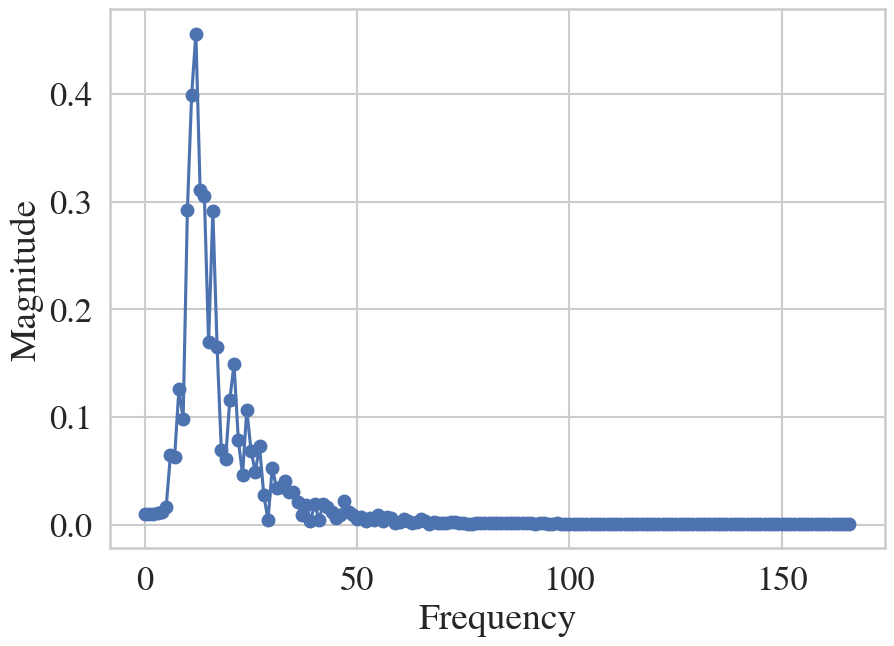

In [9]:
N = len(i)

T = 1/N

yf = fft(filtered)

xf = fftfreq(N, T)[:N//2]

plt.plot(2.0/N * np.abs(yf[0:N//2]),'-o')

plt.xlabel("Frequency")

plt.ylabel("Magnitude")

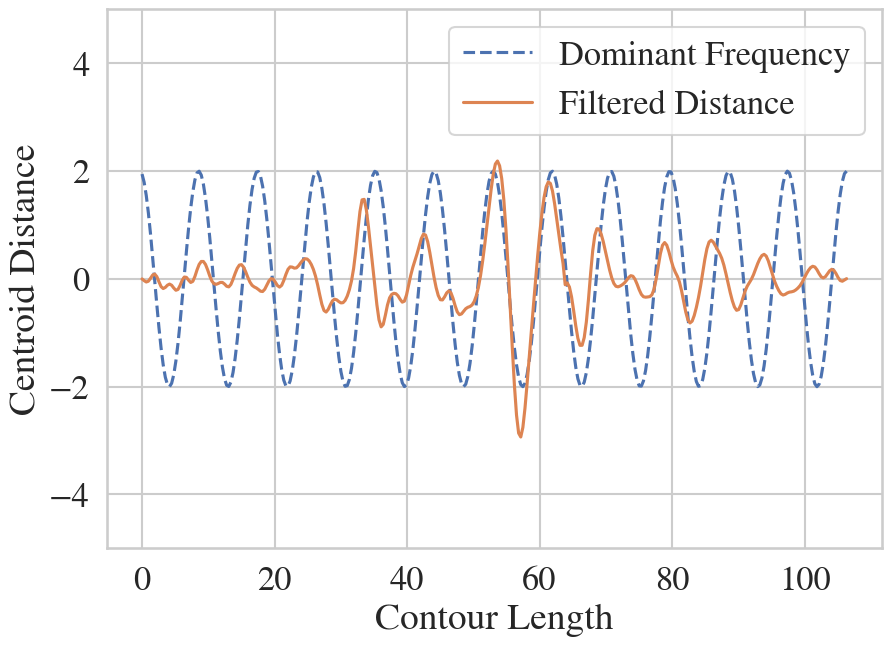

In [10]:
time_series = filtered

time = np.arange(0, len(time_series), 1)  

freq = xf[np.argmax(2.0/N * np.abs(yf[0:N//2]))]

sine_wave = np.sin(2 * np.pi * freq * (time+8) / len(time_series))*2

plt.plot(xlen,sine_wave,'--',label = "Dominant Frequency")

plt.plot(xlen,np.roll(filtered,200),label = 'Filtered Distance')

plt.ylim((-5,5))
plt.xlabel("Contour Length")
plt.ylabel("Centroid Distance")
plt.legend()